$$
\text{measurement} - \text{predicition} = \text{residual}
$$

If I want to measure my weight every day with an inaccurate scale, and I also have a biological process model that tells me I should expect to gain 0.1 kg a day I can combine my measurements from the scale and my predictions based on my process model to come up with a better estimate than either of those would provide alone. One way to do that would be to do 

$$
\text{estimate} = \text{prediction} + g \times \text{residual}
$$

So we have some weighted blend of the prediction and the measurement.

Let's rewrite that in proper notation

$$
p_k = x_{k-1} + \dot{x} dt
$$

$$
x_k = p_k + g(z_k - p_k)
$$

We can do better than this though, because we should also let the measurement trend influence our idea of the weight gain rate.

$$
\dot{x}_k = \dot{x}_{k-1} + h(z_k - p_k) / dt
$$

This expression wasn't immediately obvious to me. So here's a derivation starting from the normal notion of taking a weighted average:

$$
\begin{align}
\dot{x}_k &= \dot{x}_{k-1} + h((z_k - x_{k-1}) - \dot{x}_{k-1}dt) / dt \\
&= \dot{x}_{k-1} + h(z_k - p_k) / dt \\
\end{align}
$$

in the first line I have set the "measured rate" as the difference between the current measured value, and the previous estimated value.

So overall the algorithm iterates through

Predict:

$$
p_k = x_{k-1} + \dot{x}_{k-1} dt
$$

Update:

$$
x_k = p_k + g(z_k - p_k)
$$

$$
\dot{x}_k = \dot{x}_{k-1} + h(z_k - p_k) / dt
$$

Apparently, all the other filters in this book are just a flavor of the g-h filter. The only thing that changes is how h and g are set. Above, they are just constants. In fact, the g-h filter is not really a filter, it's a classification for a family of filters.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

/tmp/ipykernel_78516/3666197489.py:68: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, ts_measured_weight, 'ko', label="Measured", marker='o')


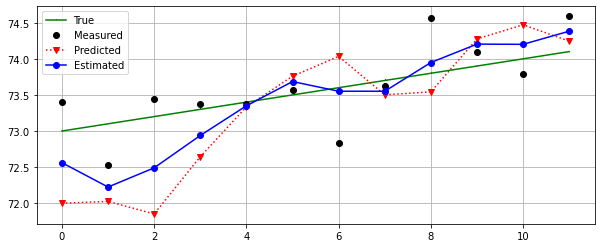

In [77]:
# This code implements the h-g filter for the person weighing example.


class InaccurateScale:
    def __init__(self, stdev):
        self.stdev = stdev
 
    def measure(self, true_weight):
        return true_weight + np.random.normal(0, self.stdev)


def run_experiment(
        true_starting_weight, true_daily_weight_gain,
        estimated_starting_weight, intial_estimated_daily_weight_gain,
        measurement_stdev,
        g, h,
        num_days,
    ):
    ts_true_weight = []
    ts_measured_weight = []
    ts_estimated_weight = []
    ts_predicted_weight = []

    scale = InaccurateScale(measurement_stdev)

    true_weight = true_starting_weight
    estimated_daily_weight_gain = intial_estimated_daily_weight_gain

    for i in range(num_days):
        # Update the true weight gain
        if i > 0:
            true_weight += true_daily_weight_gain
        # Measure the weight using our noisy scale
        measured_weight = scale.measure(true_weight)
        # Make a preciction of the weight using the process model
        if i == 0:
            # For the first day we'll use our initial estimate for the starting weight
            predicted_weight = estimated_starting_weight
        else:
            # For subsequent days predict the weight by propagating the previous estimated weight
            predicted_weight = estimated_weight + estimated_daily_weight_gain
        # Now the residual is the difference between what we measured and what we predicted
        residual = measured_weight - predicted_weight
        # The new estimated weight gain rate is a weighted blend of our previous estimated weight gain rate
        # and what the measurement tells us that the estimated weight gain rate should be
        estimated_daily_weight_gain = estimated_daily_weight_gain + h * residual
        # The new estimated weight is a weighted blend of the prediction and measurement
        estimated_weight = predicted_weight + g * residual
        # Update time series
        ts_true_weight.append(true_weight)
        ts_measured_weight.append(measured_weight)
        ts_predicted_weight.append(predicted_weight)
        ts_estimated_weight.append(estimated_weight)
    return ts_true_weight, ts_measured_weight, ts_predicted_weight, ts_estimated_weight


ts_true_weight, ts_measured_weight, ts_predicted_weight, ts_estimated_weight = run_experiment(
    true_starting_weight=73, true_daily_weight_gain=0.1,
    estimated_starting_weight=72, intial_estimated_daily_weight_gain=-1,
    measurement_stdev=0.5,
    g=0.4, h=0.33,
    num_days=12,
)

fig, ax = plt.subplots(figsize=(10, 4))
x = np.arange(len(ts_true_weight))
ax.plot(x, ts_true_weight, 'g,-', label="True")
ax.plot(x, ts_measured_weight, 'ko', label="Measured", marker='o')
ax.plot(x, ts_predicted_weight, 'rv:', label="Predicted")
ax.plot(x, ts_estimated_weight, 'bo-', label="Estimated")
ax.grid()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
